In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Summary

    * sklearn BIRCH algorithm

    * Hyperparameters: threshold and branching factor
    
    * The charge and type predictors of the data not used in the learning process.

    * Scaler for data used is MinMaxScaler.

    * See KMeans notebook for more information.

    * Results: 
        1. Highest silhouette score with 2 clusters. 

        2. No common charge/type combination between the clusters.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
from sklearn.metrics import silhouette_score

In [3]:
import jupyterthemes as jt
jt.jtplot.style(theme = 'grade3', context = 'paper', ticks=True, grid = False)

In [17]:
# Importing custom written helper functions for evaluating the clustering results
from plot_func import plot_func
from barplot_func_v2 import barplot_func_v2
from common_feature import common_feature
from silhouette_plot import silhouette_plot

## Importing scaled training data

In [6]:
# saved from KMeans analyis
scaled_data = np.load('scaled_traindata.npz', allow_pickle=True, mmap_mode='r')
scaled_data.files

['scaled_data', 'arr_names']

In [7]:
train_data = scaled_data[scaled_data.files[0]]
train_data.shape

(10000, 24)

In [8]:
feature_names = scaled_data[scaled_data.files[1]]
feature_names

array(['pt1', 'eta1', 'phi1', 'sigmaEtaEta1', 'HoverE1', 'isoTrack1',
       'isoEcal1', 'isoHcal1', 'pt2', 'eta2', 'phi2', 'sigmaEtaEta2',
       'HoverE2', 'isoTrack2', 'isoEcal2', 'isoHcal2', 'x0_-1', 'x0_1',
       'x0_EB', 'x0_EE'], dtype=object)

## Birch Clustering

In [4]:
from sklearn.cluster import Birch

### Starting with default parameters

In [9]:
threshold = [0.5]
branching_fac = [50]

#### Without global clustering

In [13]:
birch1_wgc = Birch(threshold=threshold[0], branching_factor=branching_fac[0], n_clusters=None)

In [14]:
birch1_wgc_fit = birch1_wgc.fit(train_data[:,:16])

In [15]:
np.unique(birch1_wgc_fit.labels_, return_counts=True)

(array([0, 1, 2, 3, 4]), array([2512, 1919, 1970, 2426, 1173]))

##### Clustering Evaluation

In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
# encoding charges
encoded_charge = OneHotEncoder(categories='auto').fit([[-1],[1]])

In [32]:
# encoding charge types
encoded_type = OneHotEncoder().fit([['EE'], ['EB']])

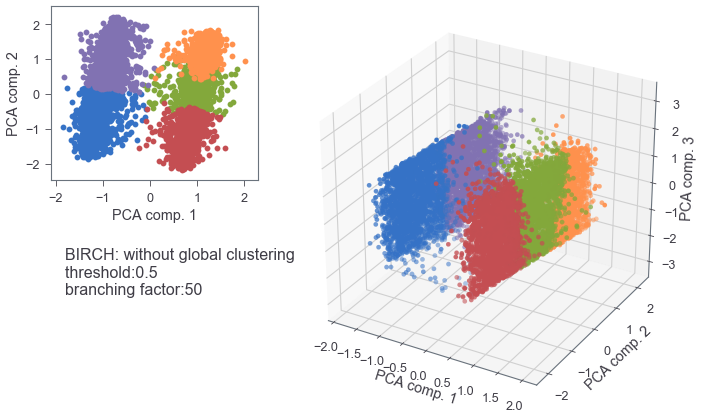

In [23]:
plot_func(data=train_data[:,:16], predicted_values=birch1_wgc_fit.labels_, text = "BIRCH: without global clustering \nthreshold:0.5 \nbranching factor:50")

In [24]:
# Sihouette Score
sil_values = []
sil_values.append(silhouette_score(train_data[:,:16], birch1_wgc_fit.labels_))
sil_values # low score

[0.24156413197360638]

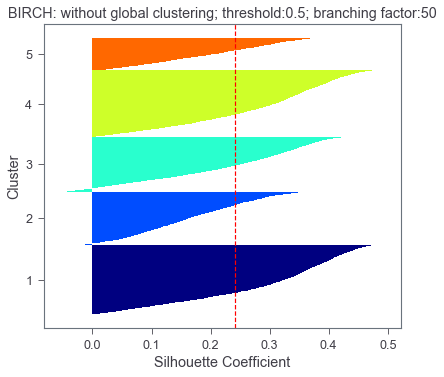

In [25]:
silhouette_plot(data=train_data[:,:16], predicted_values=birch1_wgc_fit.labels_, title = "BIRCH: without global clustering; threshold:0.5; branching factor:50")

In [33]:
common_feature(scaled_data=train_data, predicted_values=birch1_wgc_fit.labels_, n_clusters=5, 
               encoder_charge=encoded_charge, encoder_type=encoded_type)

'No common particle charge/type combination within the clusters'

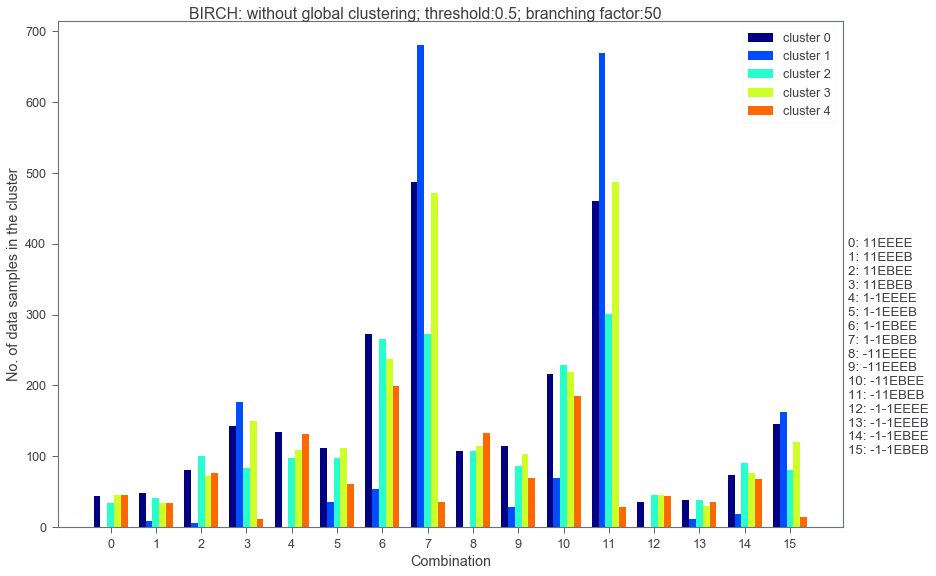

In [34]:
barplot_func_v2(training_data=train_data, pred_val=birch1_wgc_fit.labels_, n_clusters=5, encoder_charge=encoded_charge,
               encoder_type=encoded_type, bar_width=0.15, title="BIRCH: without global clustering; threshold:0.5; branching factor:50")

    * Uneven distribution of the combinations amongst the clusters.
    
    * Cluster 1 is missing combinations 0, 4, 8 and 12 all of which are of types (EE,EE)

#### With global clustering = 3

In [36]:
n_clusters = [3]

In [37]:
birch1_gc3 = Birch(threshold=threshold[0], branching_factor=branching_fac[0], n_clusters= n_clusters[0])

In [38]:
birch1_gc3_fit = birch1_gc3.fit(train_data[:,:16])

In [51]:
labels, counts = np.unique(birch1_gc3_fit.labels_, return_counts=True)
labels, counts

(array([0, 1, 2]), array([4938, 3092, 1970]))

In [52]:
params = list(birch1_gc3.get_params().values())
params

[50, True, True, 3, 0.5]

##### Clustering Evaluation

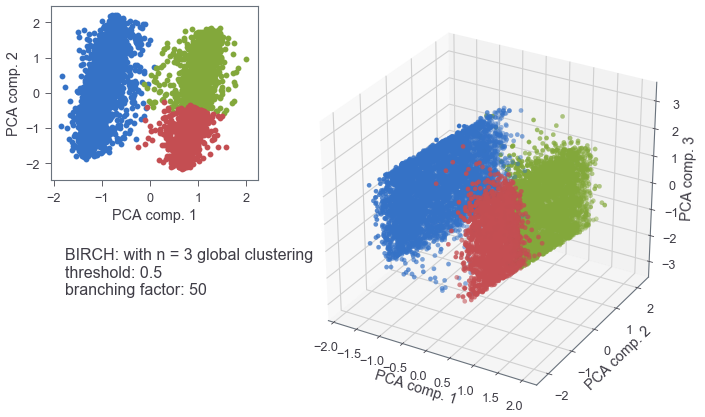

In [54]:
plot_func(data=train_data[:,:16], predicted_values=birch1_gc3_fit.labels_, 
          text = "BIRCH: with n = %d global clustering \nthreshold: %0.1f \nbranching factor: %d"%(len(labels),params[-1], params[0]))

In [43]:
# Sihouette Score
sil_values.append(silhouette_score(train_data[:,:16], birch1_gc3_fit.labels_))
sil_values # low score

[0.24156413197360638, 0.28259488101433206]

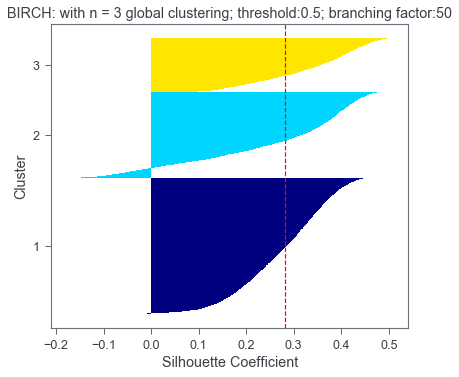

In [55]:
silhouette_plot(data=train_data[:,:16], predicted_values=birch1_gc3_fit.labels_, 
                title = "BIRCH: with n = %d global clustering; threshold:%0.1f; branching factor:%d"%(len(labels),params[-1], params[0]))

In [45]:
common_feature(scaled_data=train_data, predicted_values=birch1_gc3_fit.labels_, n_clusters=len(labels), 
               encoder_charge=encoded_charge, encoder_type=encoded_type)

'No common particle charge/type combination within the clusters'

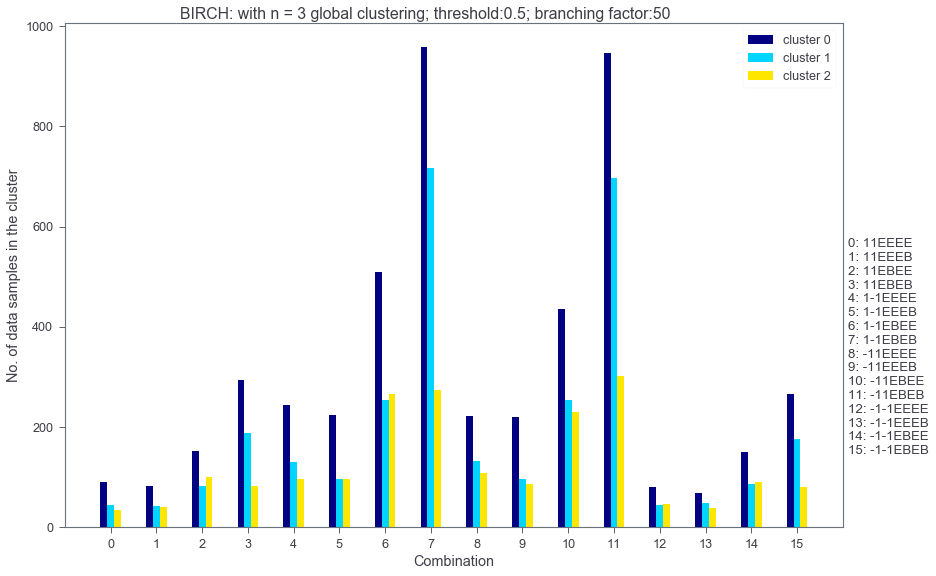

In [59]:
barplot_func_v2(training_data=train_data, pred_val=birch1_gc3_fit.labels_, n_clusters=len(labels), 
                encoder_charge=encoded_charge,  encoder_type=encoded_type, bar_width=0.15, 
                title="BIRCH: with n = %d global clustering; threshold:%0.1f; branching factor:%d"%(len(labels),params[-1], params[0]))

    * All combinations in all the clusters.
    
    * The distribution of the combinations amongst clusters 1 and 2 is uneven.
    
    * The silhouette score is better than for without global clustering

### Choosing threshold from DBSCAN elbow point

In [61]:
threshold.append(0.3)
threshold, branching_fac

([0.5, 0.3], [50])

#### Without global clustering

In [62]:
birch2_wgc = Birch(threshold=threshold[1], branching_factor=branching_fac[0], n_clusters= None)

In [63]:
birch2_wgc_fit = birch2_wgc.fit(train_data[:,:16])

In [64]:
labels, counts = np.unique(birch2_wgc_fit.labels_, return_counts=True)
labels, counts

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147]),
 array([412, 279,   5,  81,  84, 310, 149,  22,   5,   1, 229,   3, 257,
        165, 192, 299,   1, 161,  48,  17,  22,  43, 114, 121,   2,  10,
          3,   1

    * That's a lot of subclusters!
    
    * Checking the charge_type_counts (see DBSCAN notebook), the clustering does not reflect properties based on charge/type combinations. 

In [65]:
params = list(birch2_wgc.get_params().values())
params

[50, True, True, None, 0.3]

##### Clustering Evaluation

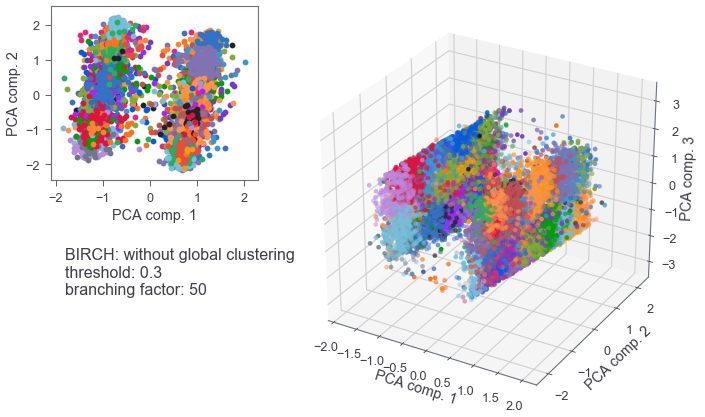

In [68]:
plot_func(data=train_data[:,:16], predicted_values=birch2_wgc_fit.labels_, 
          text = "BIRCH: without global clustering \nthreshold: %0.1f \nbranching factor: %d"%(params[-1], params[0]))

In [69]:
# Sihouette Score
sil_values.append(silhouette_score(train_data[:,:16], birch2_wgc_fit.labels_))
sil_values # low score

[0.24156413197360638, 0.28259488101433206, 0.11650269050320114]

In [70]:
common_feature(scaled_data=train_data, predicted_values=birch2_wgc_fit.labels_, n_clusters=len(labels), 
               encoder_charge=encoded_charge, encoder_type=encoded_type)

'No common particle charge/type combination within the clusters'

    * Very low silhouette score.
    
    * From the counts array, it seems like several subclusters contain outliers. 

#### With global clustering = 3

In [71]:
n_clusters

[3]

In [72]:
birch2_gc3 = Birch(threshold=threshold[1], branching_factor=branching_fac[0], n_clusters= n_clusters[0])

In [73]:
birch2_gc3_fit = birch2_gc3.fit(train_data[:,:16])

In [74]:
labels, counts = np.unique(birch2_gc3_fit.labels_, return_counts=True)
labels, counts

(array([0, 1, 2]), array([5070, 2119, 2811]))

In [75]:
params = list(birch2_gc3.get_params().values())
params

[50, True, True, 3, 0.3]

##### Clustering Evaluation

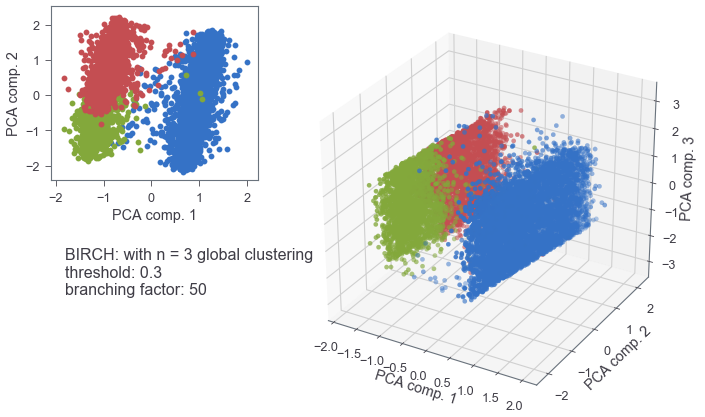

In [76]:
plot_func(data=train_data[:,:16], predicted_values=birch2_gc3_fit.labels_, 
          text = "BIRCH: with n = %d global clustering \nthreshold: %0.1f \nbranching factor: %d"%(len(labels),params[-1], params[0]))

    * With 0.5 threshold, the right cluster got divided into 2, with 0.3 threshold, the left cluster got divided into 2.
    
    * This suggests, maybe 4 clusters could be optimal?

In [77]:
# Sihouette Score
sil_values.append(silhouette_score(train_data[:,:16], birch2_gc3_fit.labels_))
sil_values # close to the score of 0.5 threshold

[0.24156413197360638,
 0.28259488101433206,
 0.11650269050320114,
 0.27633206308027025]

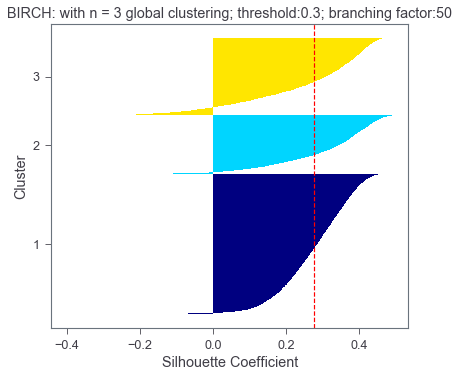

In [78]:
silhouette_plot(data=train_data[:,:16], predicted_values=birch2_gc3_fit.labels_, 
                title = "BIRCH: with n = %d global clustering; threshold:%0.1f; branching factor:%d"%(len(labels),params[-1], params[0]))

In [79]:
common_feature(scaled_data=train_data, predicted_values=birch2_gc3_fit.labels_, n_clusters=len(labels), 
               encoder_charge=encoded_charge, encoder_type=encoded_type)

'No common particle charge/type combination within the clusters'

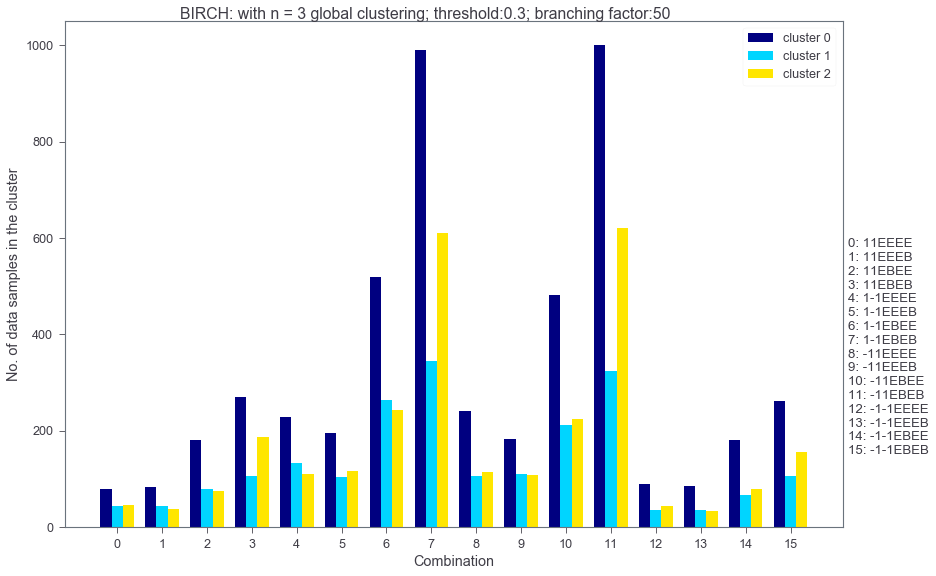

In [81]:
barplot_func_v2(training_data=train_data, pred_val=birch2_gc3_fit.labels_, n_clusters=len(labels), 
                encoder_charge=encoded_charge,  encoder_type=encoded_type, bar_width=0.25, 
                title="BIRCH: with n = %d global clustering; threshold:%0.1f; branching factor:%d"%(len(labels),params[-1], params[0]))

    * All combinations in all the clusters.
    
    * The distribution of the combinations amongst clusters 1 and 2 is uneven.
    
    * The silhouette score is better than for without global clustering

### n_clusters = 4 and varying the threshold

In [82]:
threshold_array = np.linspace(0.1, 0.6, 6)
threshold_array

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

#### threshold =0.1

In [83]:
birch1_gc4 = Birch(threshold=threshold_array[0], branching_factor=branching_fac[0], n_clusters= 4)

In [84]:
birch1_gc4_fit = birch1_gc4.fit(train_data[:,:16])

In [85]:
labels, counts = np.unique(birch1_gc4_fit.labels_, return_counts=True)
labels, counts

(array([0, 1, 2, 3]), array([2921, 2685, 2386, 2008]))

In [86]:
params = list(birch1_gc4.get_params().values())
params

[50, True, True, 4, 0.1]

##### Clustering Evaluation

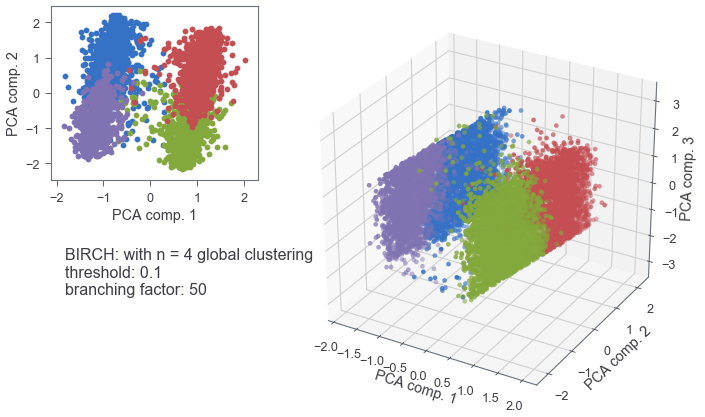

In [87]:
plot_func(data=train_data[:,:16], predicted_values=birch1_gc4_fit.labels_, 
          text = "BIRCH: with n = %d global clustering \nthreshold: %0.1f \nbranching factor: %d"%(len(labels),params[-1], params[0]))

In [88]:
# Sihouette Score
sil_values.append(silhouette_score(train_data[:,:16], birch1_gc4_fit.labels_))
sil_values # close to the score of 0.5 threshold

[0.24156413197360638,
 0.28259488101433206,
 0.11650269050320114,
 0.27633206308027025,
 0.26420844910157787]

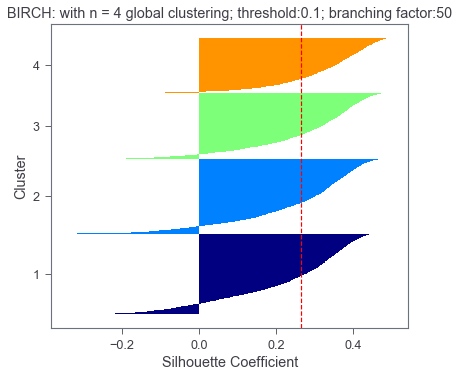

In [89]:
silhouette_plot(data=train_data[:,:16], predicted_values=birch1_gc4_fit.labels_, 
                title = "BIRCH: with n = %d global clustering; threshold:%0.1f; branching factor:%d"%(len(labels),params[-1], params[0]))

In [90]:
common_feature(scaled_data=train_data, predicted_values=birch1_gc4_fit.labels_, n_clusters=len(labels), 
               encoder_charge=encoded_charge, encoder_type=encoded_type)

'No common particle charge/type combination within the clusters'

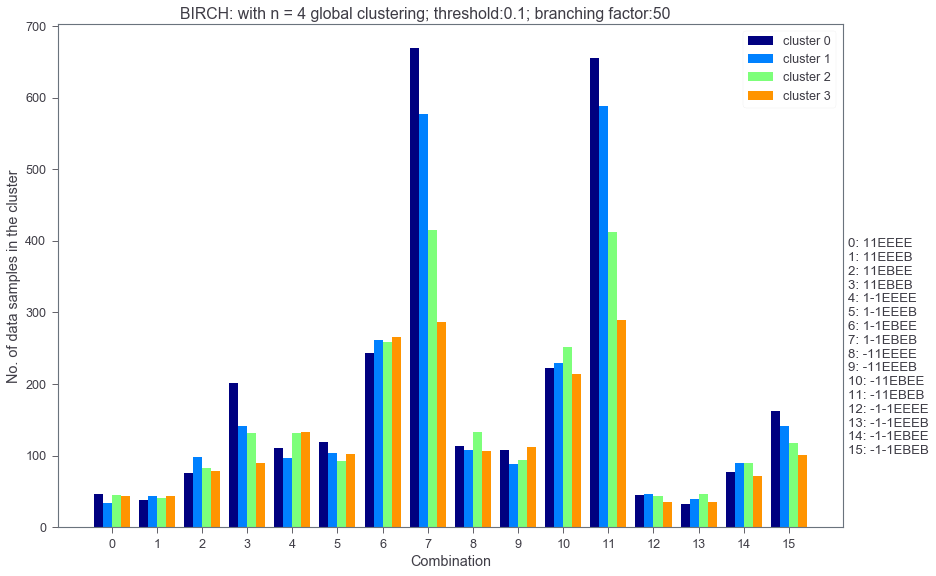

In [91]:
barplot_func_v2(training_data=train_data, pred_val=birch1_gc4_fit.labels_, n_clusters=len(labels), 
                encoder_charge=encoded_charge,  encoder_type=encoded_type, bar_width=0.20, 
                title="BIRCH: with n = %d global clustering; threshold:%0.1f; branching factor:%d"%(len(labels),params[-1], params[0]))

    * All combinations in all the clusters.
    
    * The distribution of the combinations seems even amongst all clusters other than 7 and 11, and 3 and 15 where the common combination is (EB,EB).

#### threshold =0.2

In [101]:
birch2_gc4 = Birch(threshold=threshold_array[1], branching_factor=branching_fac[0], n_clusters= 4)

In [93]:
birch2_gc4_fit = birch2_gc4.fit(train_data[:,:16])

In [94]:
labels, counts = np.unique(birch2_gc4_fit.labels_, return_counts=True)
labels, counts

(array([0, 1, 2, 3]), array([2528, 2868, 2404, 2200]))

In [95]:
params = list(birch2_gc4.get_params().values())
params

[50, True, True, 4, 0.2]

##### Clustering Evaluation

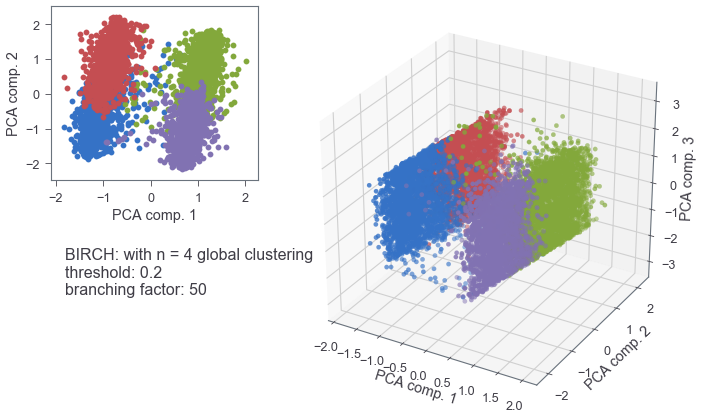

In [96]:
plot_func(data=train_data[:,:16], predicted_values=birch2_gc4_fit.labels_, 
          text = "BIRCH: with n = %d global clustering \nthreshold: %0.1f \nbranching factor: %d"%(len(labels),params[-1], params[0]))

In [97]:
# Sihouette Score
sil_values.append(silhouette_score(train_data[:,:16], birch2_gc4_fit.labels_))
sil_values # close to the score of 0.5 threshold

[0.24156413197360638,
 0.28259488101433206,
 0.11650269050320114,
 0.27633206308027025,
 0.26420844910157787,
 0.26314148126550474]

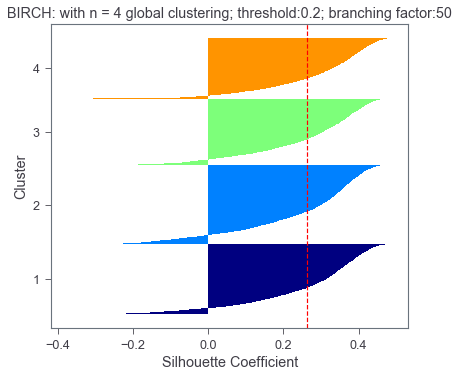

In [98]:
silhouette_plot(data=train_data[:,:16], predicted_values=birch2_gc4_fit.labels_, 
                title = "BIRCH: with n = %d global clustering; threshold:%0.1f; branching factor:%d"%(len(labels),params[-1], params[0]))

In [90]:
common_feature(scaled_data=train_data, predicted_values=birch2_gc4_fit.labels_, n_clusters=len(labels), 
               encoder_charge=encoded_charge, encoder_type=encoded_type)

'No common particle charge/type combination within the clusters'

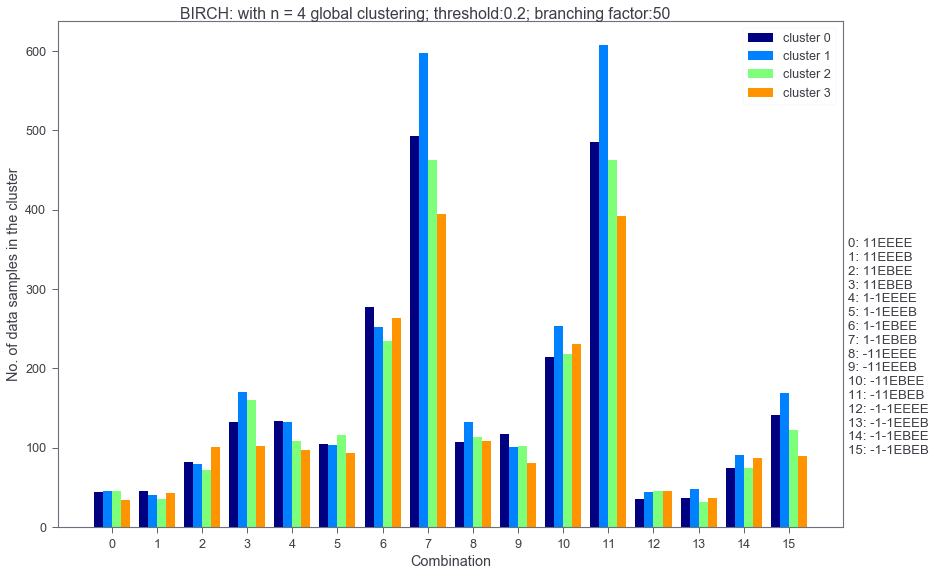

In [99]:
barplot_func_v2(training_data=train_data, pred_val=birch2_gc4_fit.labels_, n_clusters=len(labels), 
                encoder_charge=encoded_charge,  encoder_type=encoded_type, bar_width=0.20, 
                title="BIRCH: with n = %d global clustering; threshold:%0.1f; branching factor:%d"%(len(labels),params[-1], params[0]))

    * All combinations in all the clusters.
    
    * The distribution of the combinations seems similar to threshold = 0.2.

#### threshold =0.3

In [105]:
np.set_printoptions(precision=3)

In [106]:
threshold_array[2]

0.30000000000000004

In [107]:
birch3_gc4 = Birch(threshold=threshold_array[2], branching_factor=branching_fac[0], n_clusters= 4)

In [108]:
birch3_gc4_fit = birch3_gc4.fit(train_data[:,:16])

In [109]:
labels, counts = np.unique(birch3_gc4_fit.labels_, return_counts=True)
labels, counts

(array([0, 1, 2, 3]), array([2119, 2375, 2811, 2695]))

In [110]:
params = list(birch3_gc4.get_params().values())
params

[50, True, True, 4, 0.30000000000000004]

##### Clustering Evaluation

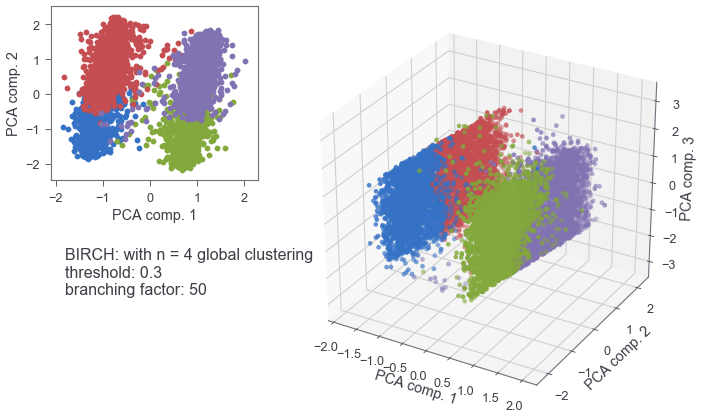

In [111]:
plot_func(data=train_data[:,:16], predicted_values=birch3_gc4_fit.labels_, 
          text = "BIRCH: with n = %d global clustering \nthreshold: %0.1f \nbranching factor: %d"%(len(labels),params[-1], params[0]))

In [112]:
# Sihouette Score
sil_values.append(silhouette_score(train_data[:,:16], birch3_gc4_fit.labels_))
sil_values # close to the score of 0.5 threshold

[0.24156413197360638,
 0.28259488101433206,
 0.11650269050320114,
 0.27633206308027025,
 0.26420844910157787,
 0.26314148126550474,
 0.26207571429500187]

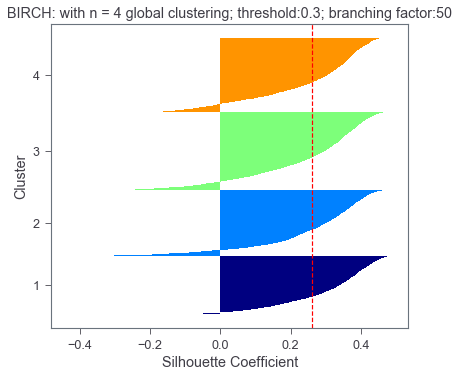

In [113]:
silhouette_plot(data=train_data[:,:16], predicted_values=birch3_gc4_fit.labels_, 
                title = "BIRCH: with n = %d global clustering; threshold:%0.1f; branching factor:%d"%(len(labels),params[-1], params[0]))

In [114]:
common_feature(scaled_data=train_data, predicted_values=birch3_gc4_fit.labels_, n_clusters=len(labels), 
               encoder_charge=encoded_charge, encoder_type=encoded_type)

'No common particle charge/type combination within the clusters'

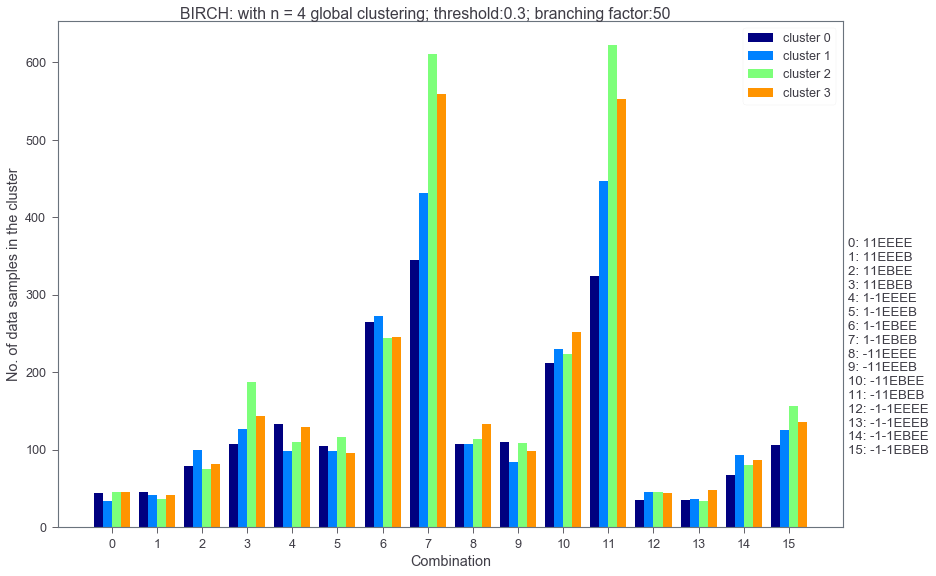

In [115]:
barplot_func_v2(training_data=train_data, pred_val=birch3_gc4_fit.labels_, n_clusters=len(labels), 
                encoder_charge=encoded_charge,  encoder_type=encoded_type, bar_width=0.20, 
                title="BIRCH: with n = %d global clustering; threshold:%0.1f; branching factor:%d"%(len(labels),params[-1], params[0]))

    * All combinations in all the clusters.
    
    * The distribution of the combinations seems similar to threshold = 0.1.
    
    * Threshold doesn't seem to affect the clustering significantly.

#### threshold =0.6

In [116]:
threshold_array[-1]

0.6

In [117]:
birch6_gc4 = Birch(threshold=threshold_array[-1], branching_factor=branching_fac[0], n_clusters= 4)

In [118]:
birch6_gc4_fit = birch6_gc4.fit(train_data[:,:16])

/home/sameer/datascience/lib/python3.6/site-packages/sklearn/cluster/birch.py:627: ConvergenceWarning: Number of subclusters found (3) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


    * With threshold = 0.6, only 3 subclusters found.

In [119]:
birch6_gc3 = Birch(threshold=threshold_array[-1], branching_factor=branching_fac[0], n_clusters= 3)

In [120]:
birch6_gc3_fit = birch6_gc3.fit(train_data[:,:16])

In [121]:
labels, counts = np.unique(birch6_gc3_fit.labels_, return_counts=True)
labels, counts

(array([0, 1, 2]), array([2375, 4920, 2705]))

In [122]:
params = list(birch6_gc3.get_params().values())
params

[50, True, True, 3, 0.6]

##### Clustering Evaluation

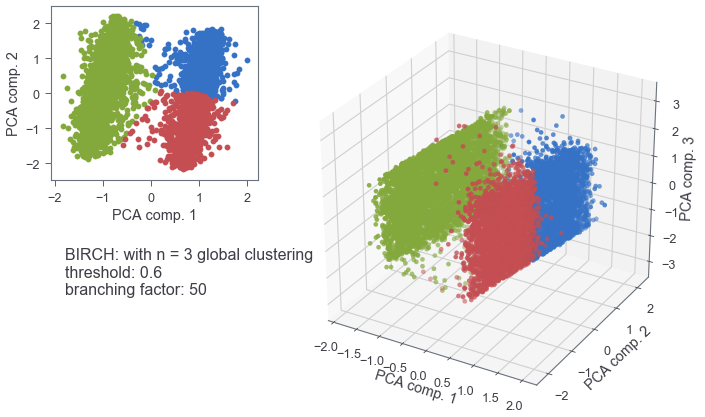

In [123]:
plot_func(data=train_data[:,:16], predicted_values=birch6_gc3_fit.labels_, 
          text = "BIRCH: with n = %d global clustering \nthreshold: %0.1f \nbranching factor: %d"%(len(labels),params[-1], params[0]))

In [124]:
# Sihouette Score
sil_values.append(silhouette_score(train_data[:,:16], birch6_gc3_fit.labels_))
sil_values # close to the score of 0.5 threshold

[0.24156413197360638,
 0.28259488101433206,
 0.11650269050320114,
 0.27633206308027025,
 0.26420844910157787,
 0.26314148126550474,
 0.26207571429500187,
 0.2881783288594542]

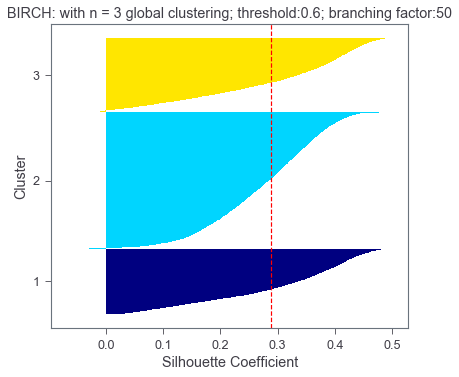

In [125]:
silhouette_plot(data=train_data[:,:16], predicted_values=birch6_gc3_fit.labels_, 
                title = "BIRCH: with n = %d global clustering; threshold:%0.1f; branching factor:%d"%(len(labels),params[-1], params[0]))

In [126]:
common_feature(scaled_data=train_data, predicted_values=birch6_gc3_fit.labels_, n_clusters=len(labels), 
               encoder_charge=encoded_charge, encoder_type=encoded_type)

'No common particle charge/type combination within the clusters'

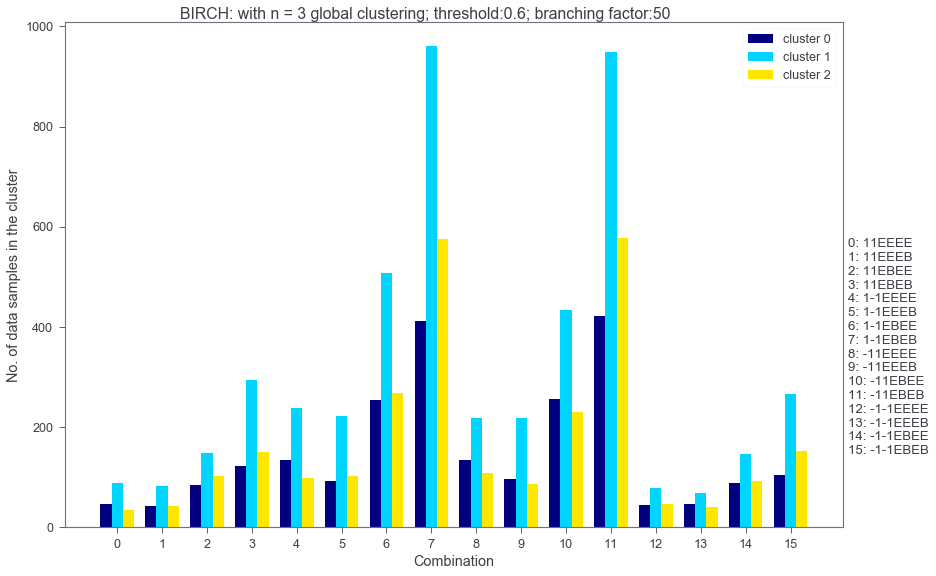

In [128]:
barplot_func_v2(training_data=train_data, pred_val=birch6_gc3_fit.labels_, n_clusters=len(labels), 
                encoder_charge=encoded_charge,  encoder_type=encoded_type, bar_width=0.25, 
                title="BIRCH: with n = %d global clustering; threshold:%0.1f; branching factor:%d"%(len(labels),params[-1], params[0]))

    * All combinations in all the clusters.

In [129]:
sil_values

[0.24156413197360638,
 0.28259488101433206,
 0.11650269050320114,
 0.27633206308027025,
 0.26420844910157787,
 0.26314148126550474,
 0.26207571429500187,
 0.2881783288594542]

### threshold =0.6 but with 2 clusters

In [130]:
threshold_array[-1]

0.6

In [131]:
birch6_gc2 = Birch(threshold=threshold_array[-1], branching_factor=branching_fac[0], n_clusters= 2)

In [132]:
birch6_gc2_fit = birch6_gc2.fit(train_data[:,:16])

In [133]:
labels, counts = np.unique(birch6_gc2_fit.labels_, return_counts=True)
labels, counts

(array([0, 1]), array([5080, 4920]))

In [134]:
params = list(birch6_gc2.get_params().values())
params

[50, True, True, 2, 0.6]

##### Clustering Evaluation

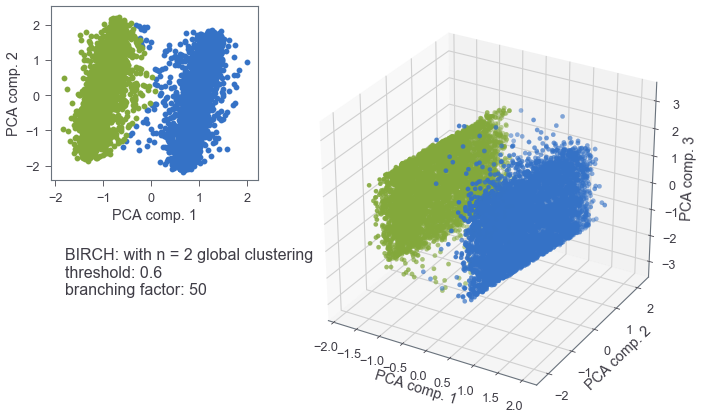

In [135]:
plot_func(data=train_data[:,:16], predicted_values=birch6_gc2_fit.labels_, 
          text = "BIRCH: with n = %d global clustering \nthreshold: %0.1f \nbranching factor: %d"%(len(labels),params[-1], params[0]))

In [136]:
# Sihouette Score
sil_values.append(silhouette_score(train_data[:,:16], birch6_gc2_fit.labels_))
sil_values # 2 clusters it is. 

[0.24156413197360638,
 0.28259488101433206,
 0.11650269050320114,
 0.27633206308027025,
 0.26420844910157787,
 0.26314148126550474,
 0.26207571429500187,
 0.2881783288594542,
 0.33683323587634856]

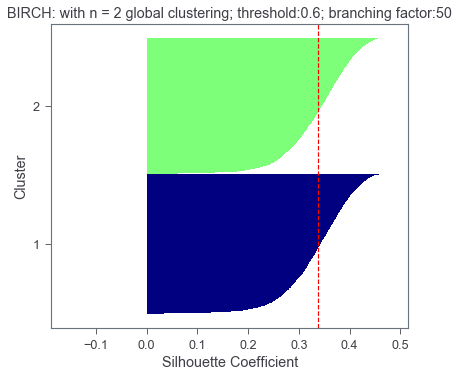

In [137]:
silhouette_plot(data=train_data[:,:16], predicted_values=birch6_gc2_fit.labels_, 
                title = "BIRCH: with n = %d global clustering; threshold:%0.1f; branching factor:%d"%(len(labels),params[-1], params[0]))

In [138]:
common_feature(scaled_data=train_data, predicted_values=birch6_gc2_fit.labels_, n_clusters=len(labels), 
               encoder_charge=encoded_charge, encoder_type=encoded_type)

'No common particle charge/type combination within the clusters'

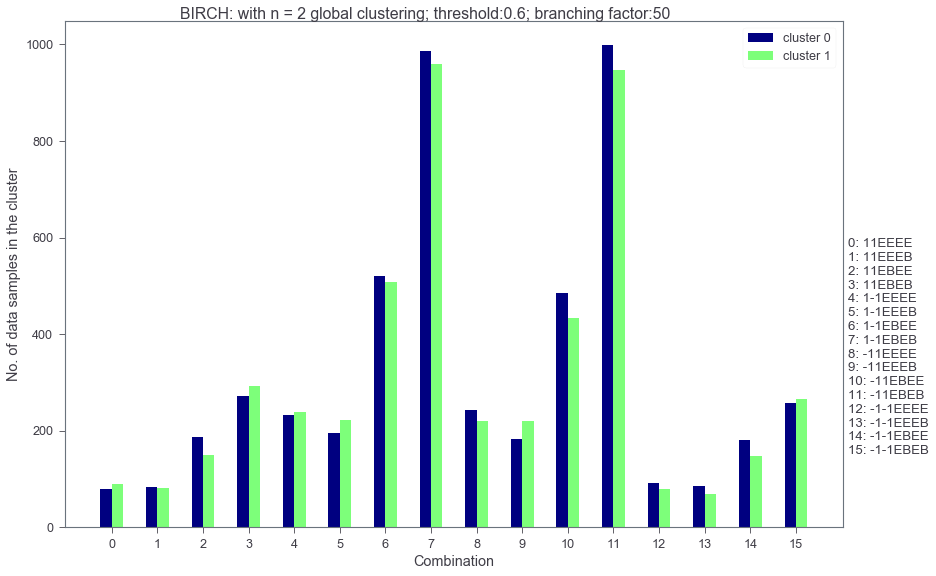

In [139]:
barplot_func_v2(training_data=train_data, pred_val=birch6_gc2_fit.labels_, n_clusters=len(labels), 
                encoder_charge=encoded_charge,  encoder_type=encoded_type, bar_width=0.25, 
                title="BIRCH: with n = %d global clustering; threshold:%0.1f; branching factor:%d"%(len(labels),params[-1], params[0]))

    * All combinations in all the clusters
    
    * Highest silhouette score
    
    * Corroborates with other algorithms